In [1]:
pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: imports y carga de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 120

df = pd.read_csv("metrics_raw.csv")
df.head()

,game_id,pair_id,agent,opponent,agent_is_first,result,result_label,moves_agent,moves_total,complexity_total_ns,response_time_mean_ms,response_time_min_ms,response_time_max_ms,available_actions_mean,available_actions_min,available_actions_max,random_seed
0,1,Random_vs_RandomBeater1,Random,RandomBeater1,0,-1,loss,4,9,112700,0.028175,0.0225,0.0395,7.000000,7,7,3523417962181357571
1,1,Random_vs_RandomBeater1,RandomBeater1,Random,1,1,win,5,9,707500,0.141500,0.1246,0.1967,7.000000,7,7,3523417962181357571
2,2,Random_vs_RandomBeater1,Random,RandomBeater1,1,-1,loss,9,18,216200,0.024022,0.0222,0.0303,6.888889,6,7,7629093851655777169
3,2,Random_vs_RandomBeater1,RandomBeater1,Random,0,1,win,9,18,1535700,0.170633,0.1106,0.2515,6.777778,6,7,7629093851655777169
4,3,Random_vs_RandomBeater1,Random,RandomBeater1,1,-1,loss,11,22,256500,0.023318,0.0206,0.0406,7.000000,7,7,9000249537592615419


In [3]:

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 120

df = pd.read_csv("metrics_raw.csv")

# Métricas derivadas básicas a nivel de partida
df["complexity_ms"] = df["complexity_total_ns"] / 1e6
df["complexity_per_move_ms"] = df["complexity_total_ns"] / 1e6 / df["moves_agent"].replace(0, np.nan)
df["complexity_per_action_ms"] = df["complexity_total_ns"] / 1e6 / (
    (df["moves_agent"] * df["available_actions_mean"]).replace(0, np.nan)
)

# Etiqueta binaria para victoria
df["is_win"] = (df["result"] == 1).astype(int)
df["is_loss"] = (df["result"] == -1).astype(int)
df["is_draw"] = (df["result"] == 0).astype(int)

df.head()


,game_id,pair_id,agent,opponent,agent_is_first,result,result_label,moves_agent,moves_total,complexity_total_ns,...,available_actions_mean,available_actions_min,available_actions_max,random_seed,complexity_ms,complexity_per_move_ms,complexity_per_action_ms,is_win,is_loss,is_draw
0,1,Random_vs_RandomBeater1,Random,RandomBeater1,0,-1,loss,4,9,112700,...,7.000000,7,7,3523417962181357571,0.1127,0.028175,0.004025,0,1,0
1,1,Random_vs_RandomBeater1,RandomBeater1,Random,1,1,win,5,9,707500,...,7.000000,7,7,3523417962181357571,0.7075,0.141500,0.020214,1,0,0
2,2,Random_vs_RandomBeater1,Random,RandomBeater1,1,-1,loss,9,18,216200,...,6.888889,6,7,7629093851655777169,0.2162,0.024022,0.003487,0,1,0
3,2,Random_vs_RandomBeater1,RandomBeater1,Random,0,1,win,9,18,1535700,...,6.777778,6,7,7629093851655777169,1.5357,0.170633,0.025175,1,0,0
4,3,Random_vs_RandomBeater1,Random,RandomBeater1,1,-1,loss,11,22,256500,...,7.000000,7,7,9000249537592615419,0.2565,0.023318,0.003331,0,1,0


In [4]:
# Cell 2: métricas base agregadas por agente

def summarise_by_agent(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("agent")

    summary = grouped.agg(
        games=("game_id", "nunique"),
        wins=("result", lambda x: (x == 1).sum()),
        draws=("result", lambda x: (x == 0).sum()),
        losses=("result", lambda x: (x == -1).sum()),
        mean_moves_agent=("moves_agent", "mean"),
        mean_moves_total=("moves_total", "mean"),
        mean_complexity_ms=("complexity_total_ns", lambda x: x.mean() / 1e6),
        total_complexity_s=("complexity_total_ns", lambda x: x.sum() / 1e9),
        mean_rt_mean_ms=("response_time_mean_ms", "mean"),
        mean_rt_max_ms=("response_time_max_ms", "mean"),
        mean_available_actions=("available_actions_mean", "mean"),
    )

    summary["win_rate"] = summary["wins"] / summary["games"]
    summary["draw_rate"] = summary["draws"] / summary["games"]
    summary["loss_rate"] = summary["losses"] / summary["games"]

    return summary.sort_values("win_rate", ascending=False)


agent_summary = summarise_by_agent(df)
agent_summary


,games,wins,draws,losses,mean_moves_agent,mean_moves_total,mean_complexity_ms,total_complexity_s,mean_rt_mean_ms,mean_rt_max_ms,mean_available_actions,win_rate,draw_rate,loss_rate
agent,,,,,,,,,,,,,,
MCTS1,400,338,1,61,8.570,16.7975,4236.702167,1694.680867,497.773746,627.215134,6.905167,0.8450,0.0025,0.1525
RandomBeaterPro,400,302,1,97,7.730,15.2125,13046.888836,5218.755534,1654.292249,2072.782740,6.918215,0.7550,0.0025,0.2425
RLPolicy,400,209,2,189,7.440,14.8025,8.630838,3.452335,1.111450,1.751059,6.931281,0.5225,0.0050,0.4725
RandomBeater1,400,144,1,255,8.425,17.0025,1.661758,0.664703,0.186273,0.258433,6.907811,0.3600,0.0025,0.6375
Random,400,4,1,395,6.170,12.8550,0.446105,0.178442,0.079326,0.106708,6.969178,0.0100,0.0025,0.9875


In [5]:
# Cell 3: métricas por agente vs oponente (match-ups)

pair_summary = (
    df
    .groupby(["agent", "opponent"])
    .agg(
        games=("game_id", "nunique"),
        wins=("result", lambda x: (x == 1).sum()),
        draws=("result", lambda x: (x == 0).sum()),
        losses=("result", lambda x: (x == -1).sum()),
        win_rate=("result", lambda x: (x == 1).mean()),
        mean_moves_agent=("moves_agent", "mean"),
        mean_moves_total=("moves_total", "mean"),
        mean_complexity_ms=("complexity_total_ns", lambda x: x.mean() / 1e6),
        mean_rt_mean_ms=("response_time_mean_ms", "mean"),
        mean_rt_max_ms=("response_time_max_ms", "mean"),
    )
    .reset_index()
)
pair_summary


,agent,opponent,games,wins,draws,losses,win_rate,mean_moves_agent,mean_moves_total,mean_complexity_ms,mean_rt_mean_ms,mean_rt_max_ms
0,MCTS1,RLPolicy,100,85,0,15,0.85,8.86,17.33,3492.879693,388.006636,504.009872
1,MCTS1,Random,100,100,0,0,1.00,6.73,12.95,3961.078485,604.267810,723.942063
2,MCTS1,RandomBeater1,100,87,0,13,0.87,9.48,18.60,3868.894982,411.118524,505.350653
3,MCTS1,RandomBeaterPro,100,66,1,33,0.66,9.21,18.31,5623.955508,587.702015,775.557948
4,RLPolicy,MCTS1,100,15,0,85,0.15,8.47,17.33,9.055161,1.053654,1.757666
5,RLPolicy,Random,100,99,1,0,0.99,5.38,10.19,5.272358,0.964294,1.432166
6,RLPolicy,RandomBeater1,100,71,1,28,0.71,8.35,16.43,9.119172,0.995291,1.603639
7,RLPolicy,RandomBeaterPro,100,24,0,76,0.24,7.56,15.26,11.076662,1.432561,2.210767
8,Random,MCTS1,100,0,0,100,0.00,6.22,12.95,0.623279,0.101453,0.119361
9,Random,RLPolicy,100,0,1,99,0.00,4.81,10.19,0.316314,0.070510,0.143301


In [6]:
# Cell 4: métricas derivadas "trascendentales" por agente

summary = agent_summary.copy()

# Atajos
C = summary["mean_complexity_ms"]      # complejidad computacional media (ms por partida)
T = summary["mean_rt_max_ms"]         # tiempo de respuesta "worst-case" medio (ms)
M = summary["mean_moves_total"]       # movimientos totales por partida
V = summary["win_rate"]               # tasa de victoria (0–1)

# Evitar divisiones por cero
eps = 1e-9
V_safe = V.replace(0, np.nan)
M_safe = M.replace(0, np.nan)
C_safe = C.replace(0, np.nan)
T_safe = T.replace(0, np.nan)

# Combinaciones pedidas
summary["C_over_T"] = C_safe / T_safe                 # COMPLEJIDAD / TIEMPO DE RESPUESTA
summary["C_over_M"] = C_safe / M_safe                 # COMPLEJIDAD / MOVIMIENTOS
summary["C_over_V"] = C_safe / V_safe                 # COMPLEJIDAD / VICTORIAS

summary["T_over_M"] = T_safe / M_safe                 # TIEMPO RESPUESTA / MOVIMIENTOS
summary["T_over_V"] = T_safe / V_safe                 # TIEMPO RESPUESTA / VICTORIAS

summary["M_over_V"] = M_safe / V_safe                 # MOVIMIENTOS / VICTORIAS

# Algunas métricas curiosas adicionales
summary["efficiency_win_per_ms"] = V_safe / C_safe    # victorias por ms de complejidad
summary["efficiency_win_per_rt"] = V_safe / T_safe    # victorias por ms de tiempo de respuesta

summary


,games,wins,draws,losses,mean_moves_agent,mean_moves_total,mean_complexity_ms,total_complexity_s,mean_rt_mean_ms,mean_rt_max_ms,...,draw_rate,loss_rate,C_over_T,C_over_M,C_over_V,T_over_M,T_over_V,M_over_V,efficiency_win_per_ms,efficiency_win_per_rt
agent,,,,,,,,,,,,,,,,,,,,,
MCTS1,400,338,1,61,8.570,16.7975,4236.702167,1694.680867,497.773746,627.215134,...,0.0025,0.1525,6.754783,252.222186,5013.848718,37.339791,742.266431,19.878698,0.000199,0.001347
RandomBeaterPro,400,302,1,97,7.730,15.2125,13046.888836,5218.755534,1654.292249,2072.782740,...,0.0025,0.2425,6.294383,857.642651,17280.647465,136.255234,2745.407603,20.149007,0.000058,0.000364
RLPolicy,400,209,2,189,7.440,14.8025,8.630838,3.452335,1.111450,1.751059,...,0.0050,0.4725,4.928923,0.583066,16.518351,0.118295,3.351310,28.330144,0.060539,0.298391
RandomBeater1,400,144,1,255,8.425,17.0025,1.661758,0.664703,0.186273,0.258433,...,0.0025,0.6375,6.430142,0.097736,4.615994,0.015200,0.717868,47.229167,0.216638,1.393014
Random,400,4,1,395,6.170,12.8550,0.446105,0.178442,0.079326,0.106708,...,0.0025,0.9875,4.180597,0.034703,44.610525,0.008301,10.670850,1285.500000,0.022416,0.093713


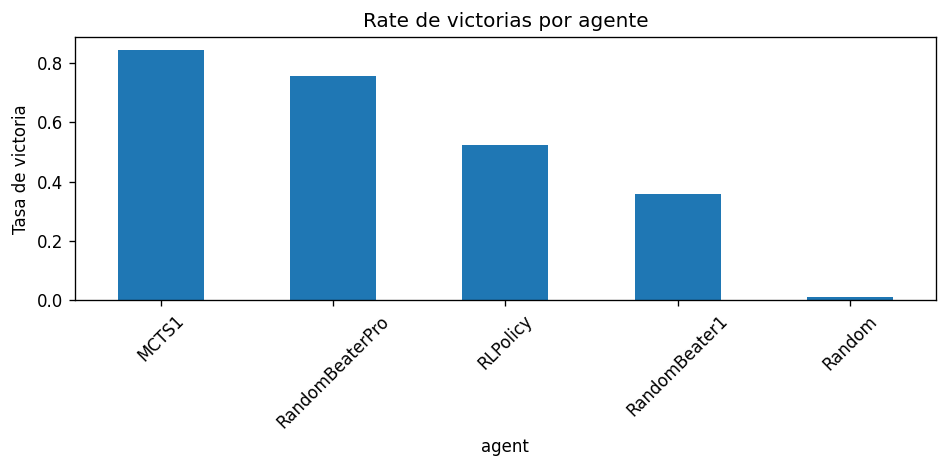

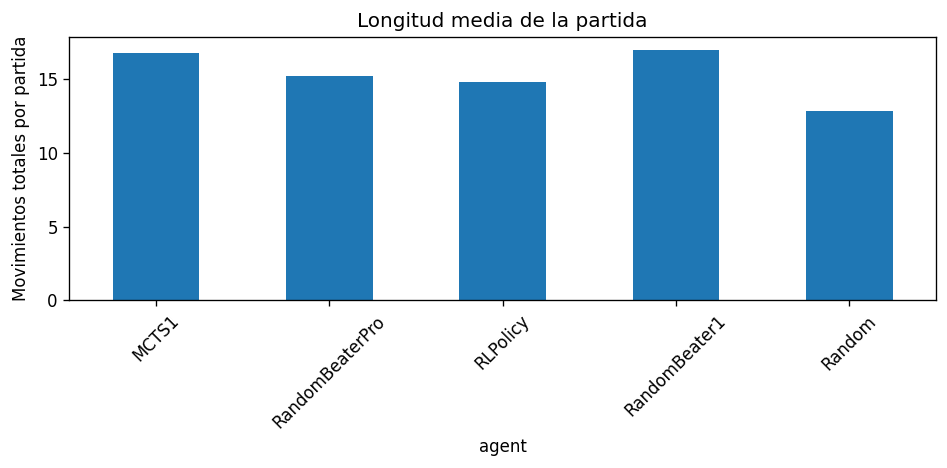

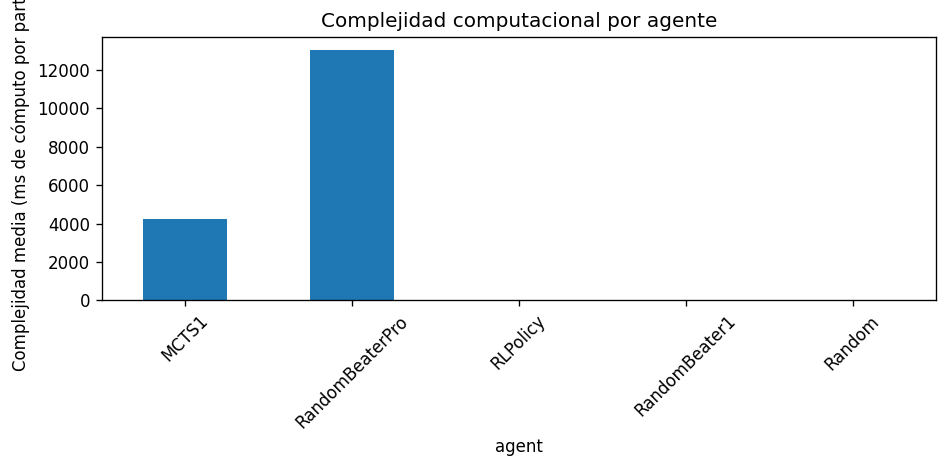

In [7]:
# Cell 5: gráficas de barra (triviales)

ax = agent_summary["win_rate"].plot(kind="bar")
ax.set_ylabel("Tasa de victoria")
ax.set_title("Rate de victorias por agente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ax = agent_summary["mean_moves_total"].plot(kind="bar")
ax.set_ylabel("Movimientos totales por partida")
ax.set_title("Longitud media de la partida")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ax = agent_summary["mean_complexity_ms"].plot(kind="bar")
ax.set_ylabel("Complejidad media (ms de cómputo por partida)")
ax.set_title("Complejidad computacional por agente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


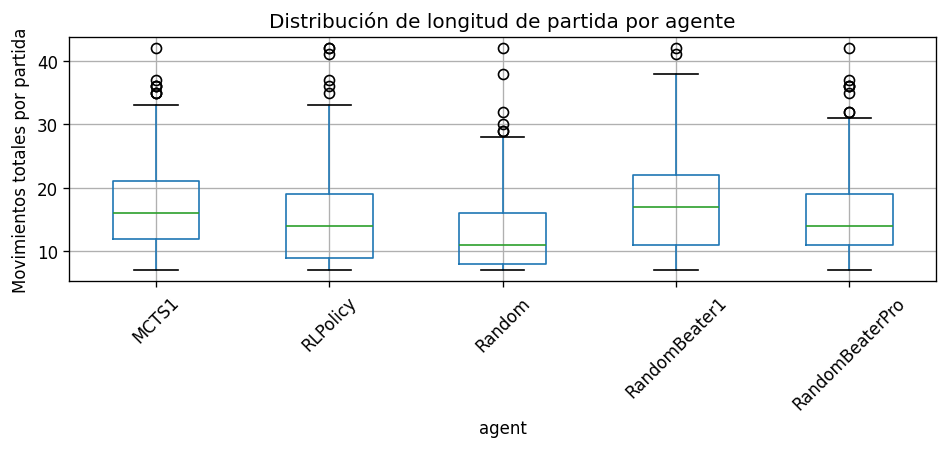

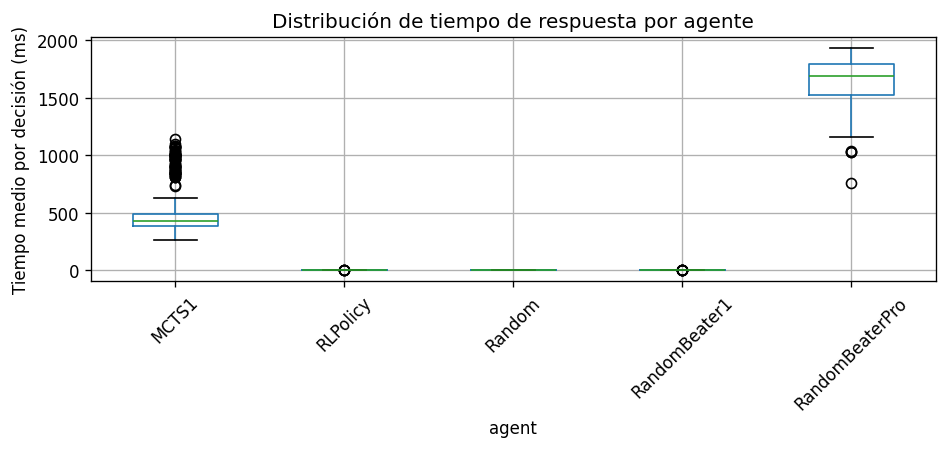

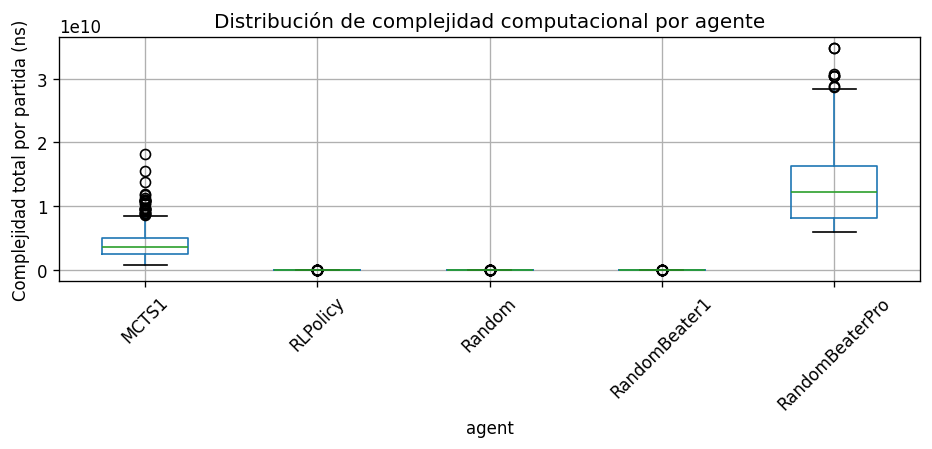

In [8]:
# Cell 6: gráficas no triviales (caja y bigotes)

# Distribución de longitud de partida por agente
df.boxplot(column="moves_total", by="agent")
plt.ylabel("Movimientos totales por partida")
plt.title("Distribución de longitud de partida por agente")
plt.suptitle("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribución de tiempos medios de decisión por partida
df.boxplot(column="response_time_mean_ms", by="agent")
plt.ylabel("Tiempo medio por decisión (ms)")
plt.title("Distribución de tiempo de respuesta por agente")
plt.suptitle("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribución de complejidad total por partida (ns)
df.boxplot(column="complexity_total_ns", by="agent")
plt.ylabel("Complejidad total por partida (ns)")
plt.title("Distribución de complejidad computacional por agente")
plt.suptitle("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Cell 7 (opcional): separación por "primer jugador" vs "segundo"

first_vs_second = (
    df
    .groupby(["agent", "agent_is_first"])
    .agg(
        games=("game_id", "nunique"),
        wins=("result", lambda x: (x == 1).sum()),
        win_rate=("result", lambda x: (x == 1).mean()),
        mean_moves_total=("moves_total", "mean"),
        mean_rt_mean_ms=("response_time_mean_ms", "mean"),
    )
    .reset_index()
)

first_vs_second["seat"] = first_vs_second["agent_is_first"].map({1: "first", 0: "second"})
first_vs_second


,agent,agent_is_first,games,wins,win_rate,mean_moves_total,mean_rt_mean_ms,seat
0,MCTS1,0,202,161,0.797030,17.326733,468.350660,second
1,MCTS1,1,198,177,0.893939,16.257576,527.791239,first
2,RLPolicy,0,179,79,0.441341,16.195531,1.129519,second
3,RLPolicy,1,221,130,0.588235,13.674208,1.096815,first
4,Random,0,210,2,0.009524,11.323810,0.080237,second
5,Random,1,190,2,0.010526,14.547368,0.078318,first
6,RandomBeater1,0,206,65,0.315534,16.116505,0.180984,second
7,RandomBeater1,1,194,79,0.407216,17.943299,0.191889,first
8,RandomBeaterPro,0,203,146,0.719212,15.945813,1621.750902,second
9,RandomBeaterPro,1,197,156,0.791878,14.456853,1687.824702,first


In [10]:
agent_summary = (
    df
    .groupby("agent")
    .agg(
        games=("game_id", "nunique"),
        wins=("is_win", "sum"),
        draws=("is_draw", "sum"),
        losses=("is_loss", "sum"),
        mean_moves_agent=("moves_agent", "mean"),
        mean_moves_total=("moves_total", "mean"),
        mean_complexity_ms=("complexity_ms", "mean"),
        total_complexity_s=("complexity_ms", lambda x: x.sum() / 1000.0),
        mean_rt_mean_ms=("response_time_mean_ms", "mean"),
        mean_rt_max_ms=("response_time_max_ms", "mean"),
        mean_available_actions=("available_actions_mean", "mean"),
        mean_complexity_per_move_ms=("complexity_per_move_ms", "mean"),
        mean_complexity_per_action_ms=("complexity_per_action_ms", "mean"),
    )
)

agent_summary["win_rate"] = agent_summary["wins"] / agent_summary["games"]
agent_summary["draw_rate"] = agent_summary["draws"] / agent_summary["games"]
agent_summary["loss_rate"] = agent_summary["losses"] / agent_summary["games"]

# Ratios “trascendentales”
C = agent_summary["mean_complexity_ms"]
T = agent_summary["mean_rt_max_ms"]
M = agent_summary["mean_moves_total"]
V = agent_summary["win_rate"]
W = agent_summary["wins"]
TotC = agent_summary["total_complexity_s"]

eps = 1e-9
C_safe = C.replace(0, np.nan)
T_safe = T.replace(0, np.nan)
M_safe = M.replace(0, np.nan)
V_safe = V.replace(0, np.nan)
W_safe = W.replace(0, np.nan)
TotC_safe = TotC.replace(0, np.nan)

agent_summary["C_over_T"] = C_safe / T_safe                      # COMPLEJIDAD/TIEMPO RESPUESTA
agent_summary["C_over_M"] = C_safe / M_safe                      # COMPLEJIDAD/MOVIMIENTOS
agent_summary["C_over_V"] = C_safe / V_safe                      # COMPLEJIDAD/VICTORIAS
agent_summary["T_over_M"] = T_safe / M_safe                      # TIEMPO RESPUESTA/MOVIMIENTOS
agent_summary["T_over_V"] = T_safe / V_safe                      # TIEMPO RESPUESTA/VICTORIAS
agent_summary["M_over_V"] = M_safe / V_safe                      # MOVIMIENTOS/VICTORIAS
agent_summary["complexity_per_win_ms"] = TotC_safe * 1000.0 / W_safe  # ms de cómputo por victoria
agent_summary["wins_per_second_compute"] = W_safe / TotC_safe         # victorias por segundo de cómputo

agent_summary.sort_values("win_rate", ascending=False)


,games,wins,draws,losses,mean_moves_agent,mean_moves_total,mean_complexity_ms,total_complexity_s,mean_rt_mean_ms,mean_rt_max_ms,...,draw_rate,loss_rate,C_over_T,C_over_M,C_over_V,T_over_M,T_over_V,M_over_V,complexity_per_win_ms,wins_per_second_compute
agent,,,,,,,,,,,,,,,,,,,,,
MCTS1,400,338,1,61,8.570,16.7975,4236.702167,1694.680867,497.773746,627.215134,...,0.0025,0.1525,6.754783,252.222186,5013.848718,37.339791,742.266431,19.878698,5013.848718,0.199448
RandomBeaterPro,400,302,1,97,7.730,15.2125,13046.888836,5218.755534,1654.292249,2072.782740,...,0.0025,0.2425,6.294383,857.642651,17280.647465,136.255234,2745.407603,20.149007,17280.647465,0.057868
RLPolicy,400,209,2,189,7.440,14.8025,8.630838,3.452335,1.111450,1.751059,...,0.0050,0.4725,4.928923,0.583066,16.518351,0.118295,3.351310,28.330144,16.518351,60.538732
RandomBeater1,400,144,1,255,8.425,17.0025,1.661758,0.664703,0.186273,0.258433,...,0.0025,0.6375,6.430142,0.097736,4.615994,0.015200,0.717868,47.229167,4.615994,216.638075
Random,400,4,1,395,6.170,12.8550,0.446105,0.178442,0.079326,0.106708,...,0.0025,0.9875,4.180597,0.034703,44.610525,0.008301,10.670850,1285.500000,44.610525,22.416235


,agent,agent_is_first,games,wins,draws,losses,mean_moves_total,mean_complexity_ms,win_rate
0,MCTS1,0,202,161,1,40,17.326733,4000.665021,0.797030
1,MCTS1,1,198,177,0,21,16.257576,4477.507740,0.893939
2,RLPolicy,0,179,79,1,99,16.195531,9.082536,0.441341
3,RLPolicy,1,221,130,1,90,13.674208,8.264984,0.588235
4,Random,0,210,2,0,208,11.323810,0.372344,0.009524
5,Random,1,190,2,1,187,14.547368,0.527631,0.010526
6,RandomBeater1,0,206,65,1,140,16.116505,1.472256,0.315534
7,RandomBeater1,1,194,79,0,115,17.943299,1.862981,0.407216
8,RandomBeaterPro,0,203,146,0,57,15.945813,12973.969392,0.719212
9,RandomBeaterPro,1,197,156,1,40,14.456853,13122.029176,0.791878


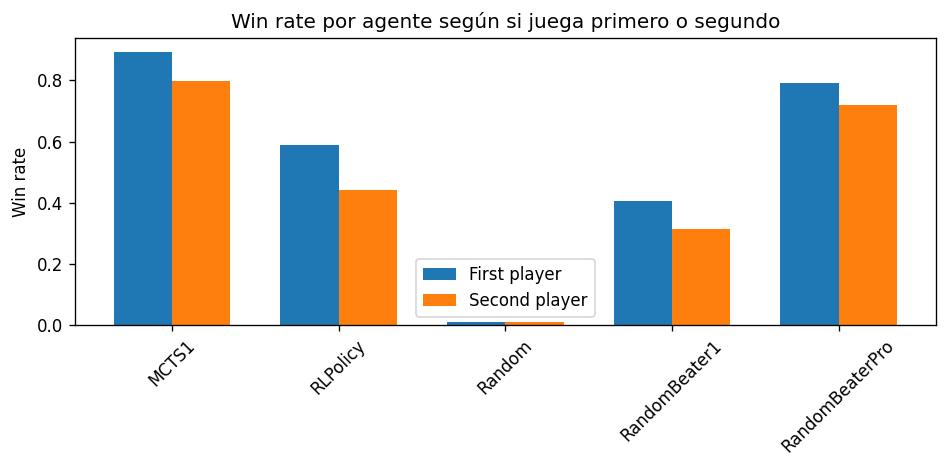

In [11]:
first_vs_second = (
    df
    .groupby(["agent", "agent_is_first"])
    .agg(
        games=("game_id", "nunique"),
        wins=("is_win", "sum"),
        draws=("is_draw", "sum"),
        losses=("is_loss", "sum"),
        mean_moves_total=("moves_total", "mean"),
        mean_complexity_ms=("complexity_ms", "mean"),
    )
    .reset_index()
)

first_vs_second["win_rate"] = first_vs_second["wins"] / first_vs_second["games"]

display(first_vs_second)

# Gráfica: barras comparando win rate como primero vs segundo
fig, ax = plt.subplots()
positions = np.arange(len(first_vs_second["agent"].unique()))
width = 0.35

for_first = first_vs_second[first_vs_second["agent_is_first"] == 1]
for_second = first_vs_second[first_vs_second["agent_is_first"] == 0]

ax.bar(positions - width/2, for_first["win_rate"], width, label="First player")
ax.bar(positions + width/2, for_second["win_rate"], width, label="Second player")

ax.set_xticks(positions)
ax.set_xticklabels(for_first["agent"], rotation=45)
ax.set_ylabel("Win rate")
ax.set_title("Win rate por agente según si juega primero o segundo")
ax.legend()
plt.tight_layout()
plt.show()


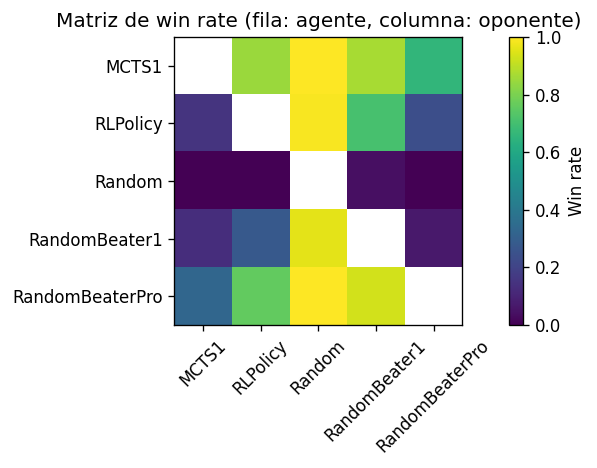

opponent,MCTS1,RLPolicy,Random,RandomBeater1,RandomBeaterPro
agent,,,,,
MCTS1,NaN,0.85,1.00,0.87,0.66
RLPolicy,0.15,NaN,0.99,0.71,0.24
Random,0.00,0.00,NaN,0.04,0.00
RandomBeater1,0.13,0.28,0.96,NaN,0.07
RandomBeaterPro,0.33,0.76,1.00,0.93,NaN


In [12]:
pair_summary = (
    df
    .groupby(["agent", "opponent"])
    .agg(
        games=("game_id", "nunique"),
        wins=("is_win", "sum"),
        draws=("is_draw", "sum"),
        losses=("is_loss", "sum"),
    )
    .reset_index()
)
pair_summary["win_rate"] = pair_summary["wins"] / pair_summary["games"]

matrix = pair_summary.pivot(index="agent", columns="opponent", values="win_rate")

fig, ax = plt.subplots()
im = ax.imshow(matrix.values, vmin=0, vmax=1, aspect="equal")

ax.set_xticks(range(len(matrix.columns)))
ax.set_xticklabels(matrix.columns, rotation=45)
ax.set_yticks(range(len(matrix.index)))
ax.set_yticklabels(matrix.index)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Win rate")

ax.set_title("Matriz de win rate (fila: agente, columna: oponente)")
plt.tight_layout()
plt.show()

matrix


C:\Users\xretr\AppData\Local\Temp\ipykernel_32056\4185393035.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_time = df.groupby("agent", group_keys=True).apply(add_cum_metrics).reset_index(drop=True)


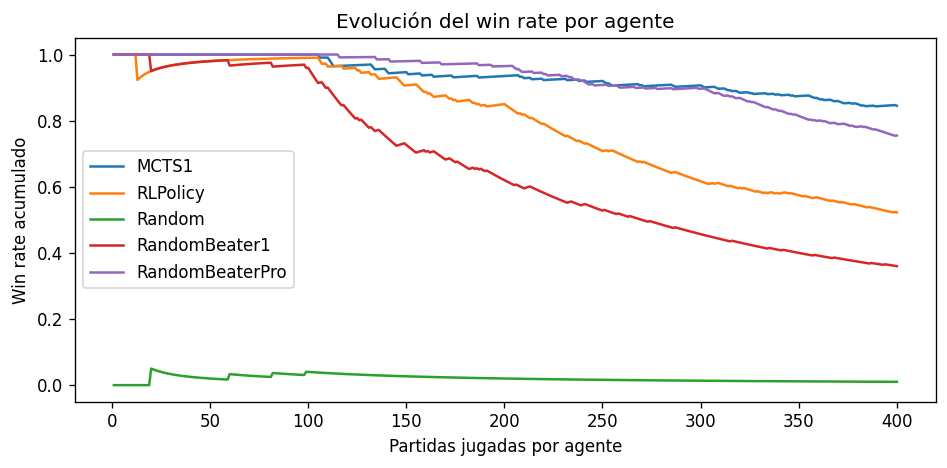

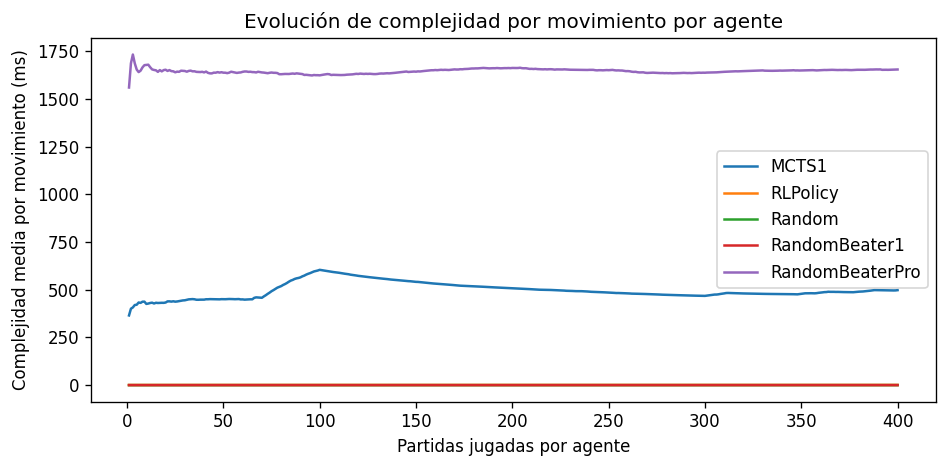

In [13]:
def add_cum_metrics(group: pd.DataFrame) -> pd.DataFrame:
    group = group.sort_values("game_id").copy()
    group["game_index_agent"] = np.arange(1, len(group) + 1)
    wins = (group["result"] == 1).astype(int)
    group["cum_wins"] = wins.cumsum()
    group["cum_win_rate"] = group["cum_wins"] / group["game_index_agent"]
    group["complexity_per_move_ms"] = group["complexity_ms"] / group["moves_agent"].replace(0, np.nan)
    group["cum_mean_complexity_per_move_ms"] = group["complexity_per_move_ms"].expanding().mean()
    return group

df_time = df.groupby("agent", group_keys=True).apply(add_cum_metrics).reset_index(drop=True)

# Línea: win rate acumulado por agente
fig, ax = plt.subplots()
for agent, sub in df_time.groupby("agent"):
    ax.plot(sub["game_index_agent"], sub["cum_win_rate"], label=agent)

ax.set_xlabel("Partidas jugadas por agente")
ax.set_ylabel("Win rate acumulado")
ax.set_title("Evolución del win rate por agente")
ax.legend()
plt.tight_layout()
plt.show()

# Línea: complejidad media por movimiento acumulada
fig, ax = plt.subplots()
for agent, sub in df_time.groupby("agent"):
    ax.plot(sub["game_index_agent"], sub["cum_mean_complexity_per_move_ms"], label=agent)

ax.set_xlabel("Partidas jugadas por agente")
ax.set_ylabel("Complejidad media por movimiento (ms)")
ax.set_title("Evolución de complejidad por movimiento por agente")
ax.legend()
plt.tight_layout()
plt.show()


C:\Users\xretr\AppData\Local\Temp\ipykernel_32056\2509522706.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_roll = df.groupby("agent", group_keys=True).apply(add_rolling).reset_index(drop=True)


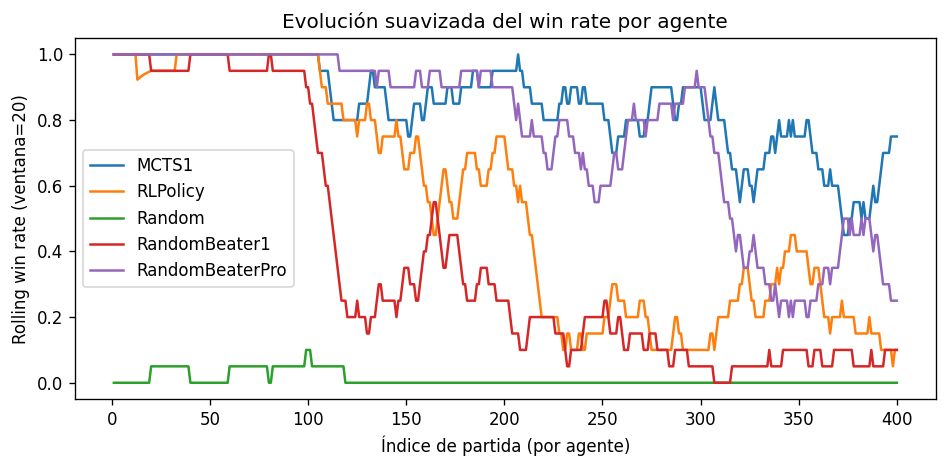

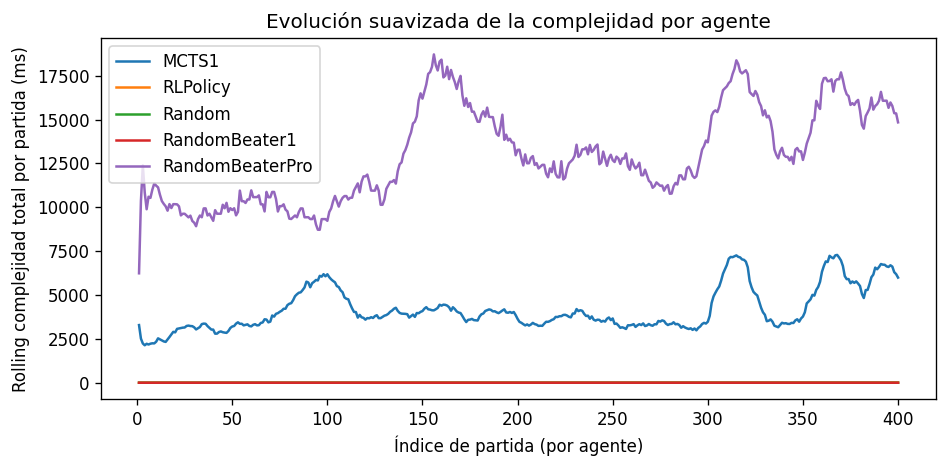

In [14]:
def add_rolling(group: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    group = group.sort_values("game_id").copy()
    group["idx_agent"] = np.arange(1, len(group) + 1)
    win = (group["result"] == 1).astype(float)
    group["rolling_win_rate"] = win.rolling(window, min_periods=1).mean()
    comp_ms = group["complexity_ms"]
    group["rolling_complexity_ms"] = comp_ms.rolling(window, min_periods=1).mean()
    return group

df_roll = df.groupby("agent", group_keys=True).apply(add_rolling).reset_index(drop=True)

# Gráfica: rolling win rate
fig, ax = plt.subplots()
for agent, sub in df_roll.groupby("agent"):
    ax.plot(sub["idx_agent"], sub["rolling_win_rate"], label=agent)

ax.set_xlabel("Índice de partida (por agente)")
ax.set_ylabel(f"Rolling win rate (ventana=20)")
ax.set_title("Evolución suavizada del win rate por agente")
ax.legend()
plt.tight_layout()
plt.show()

# Gráfica: rolling complejidad
fig, ax = plt.subplots()
for agent, sub in df_roll.groupby("agent"):
    ax.plot(sub["idx_agent"], sub["rolling_complexity_ms"], label=agent)

ax.set_xlabel("Índice de partida (por agente)")
ax.set_ylabel("Rolling complejidad total por partida (ms)")
ax.set_title("Evolución suavizada de la complejidad por agente")
ax.legend()
plt.tight_layout()
plt.show()


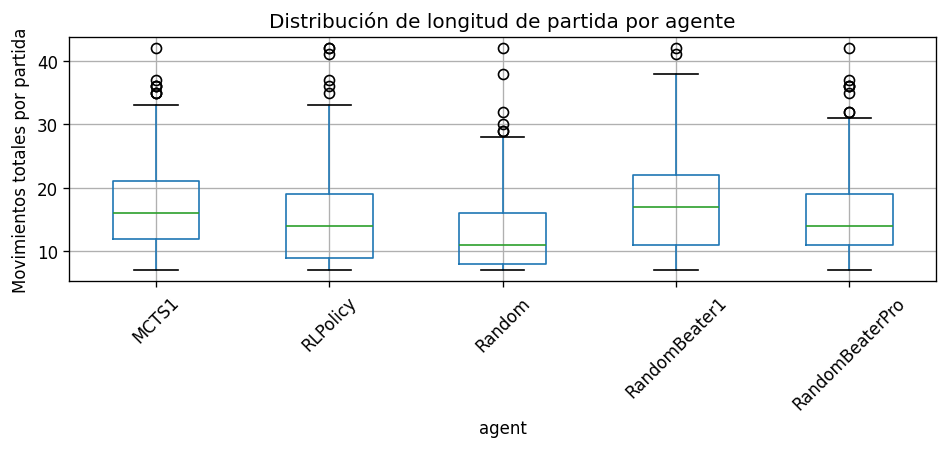

In [15]:
df.boxplot(column="moves_total", by="agent")
plt.ylabel("Movimientos totales por partida")
plt.title("Distribución de longitud de partida por agente")
plt.suptitle("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


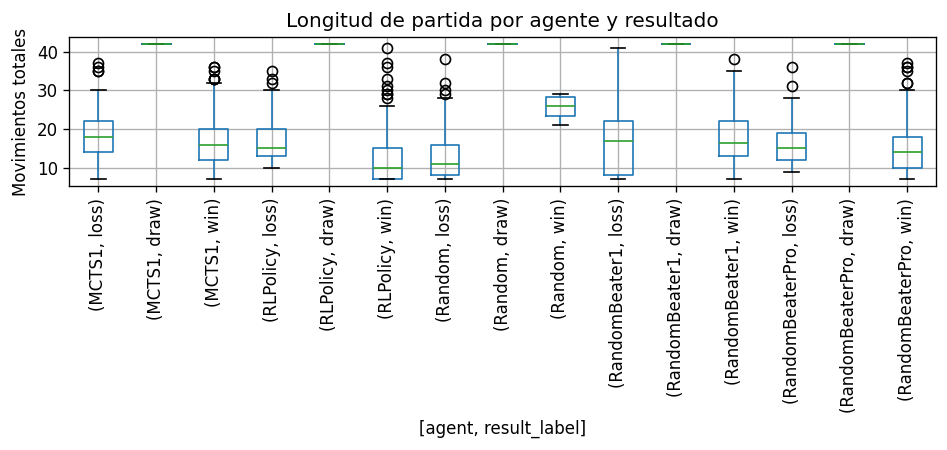

In [16]:
# Para evitar demasiadas combinaciones, filtramos draws si son pocos
df_result = df.copy()
df_result["result_label"] = pd.Categorical(df_result["result_label"], ["loss", "draw", "win"])

df_result.boxplot(column="moves_total", by=["agent", "result_label"])
plt.ylabel("Movimientos totales")
plt.title("Longitud de partida por agente y resultado")
plt.suptitle("")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


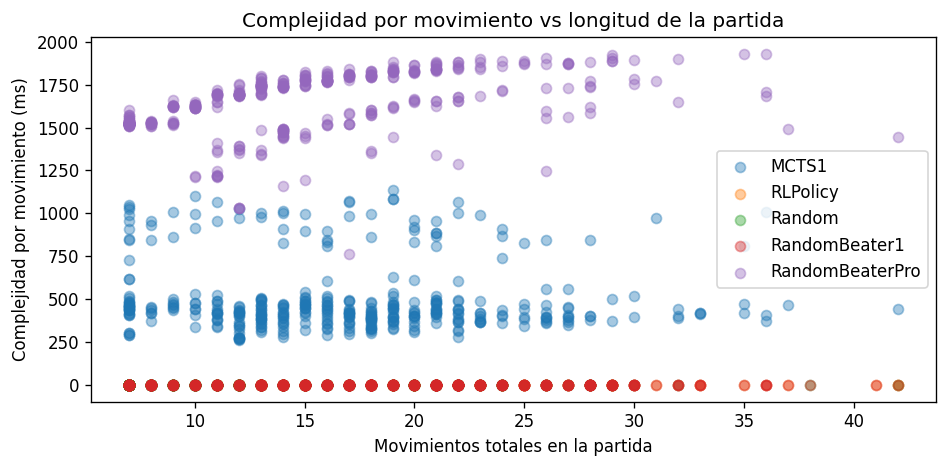

In [17]:
fig, ax = plt.subplots()
for agent, sub in df.groupby("agent"):
    ax.scatter(
        sub["moves_total"],
        sub["complexity_per_move_ms"],
        alpha=0.4,
        label=agent
    )

ax.set_xlabel("Movimientos totales en la partida")
ax.set_ylabel("Complejidad por movimiento (ms)")
ax.set_title("Complejidad por movimiento vs longitud de la partida")
ax.legend()
plt.tight_layout()
plt.show()


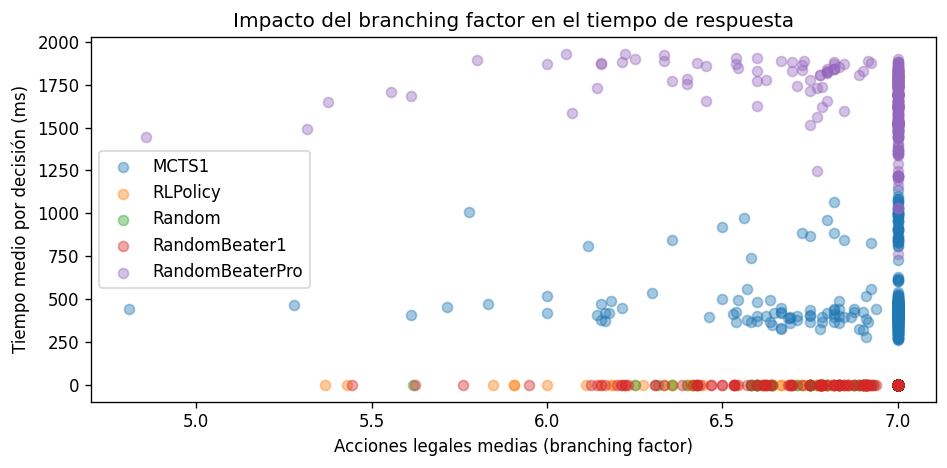

In [18]:
fig, ax = plt.subplots()
for agent, sub in df.groupby("agent"):
    ax.scatter(
        sub["available_actions_mean"],
        sub["response_time_mean_ms"],
        alpha=0.4,
        label=agent
    )

ax.set_xlabel("Acciones legales medias (branching factor)")
ax.set_ylabel("Tiempo medio por decisión (ms)")
ax.set_title("Impacto del branching factor en el tiempo de respuesta")
ax.legend()
plt.tight_layout()
plt.show()


,agent,result_label,mean_moves_total,mean_complexity_ms
0,MCTS1,draw,42.000000,9359.590800
1,MCTS1,loss,18.590164,4731.219469
2,MCTS1,win,16.399408,4132.298486
3,RLPolicy,draw,42.000000,22.349400
4,RLPolicy,loss,17.190476,10.405330
5,RLPolicy,win,12.382775,6.894877
6,Random,draw,42.000000,0.716900
7,Random,loss,12.653165,0.447061
8,Random,win,25.500000,0.284000
9,RandomBeater1,draw,42.000000,4.752900


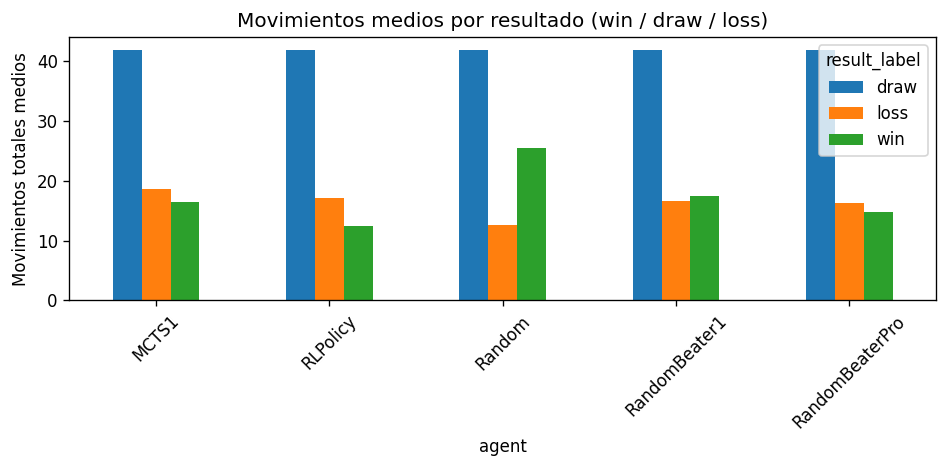

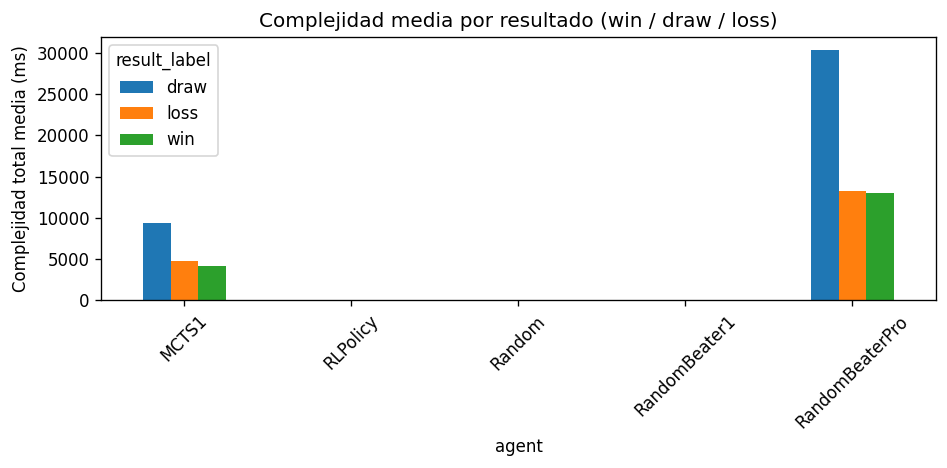

In [19]:
moves_by_result = (
    df
    .groupby(["agent", "result_label"])
    .agg(
        mean_moves_total=("moves_total", "mean"),
        mean_complexity_ms=("complexity_ms", "mean")
    )
    .reset_index()
)

display(moves_by_result)

# Gráfica: diferencia de movimientos entre win / loss
pivot_moves = moves_by_result.pivot(index="agent", columns="result_label", values="mean_moves_total")

pivot_moves.plot(kind="bar")
plt.ylabel("Movimientos totales medios")
plt.title("Movimientos medios por resultado (win / draw / loss)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica: complejidad media por resultado
pivot_comp = moves_by_result.pivot(index="agent", columns="result_label", values="mean_complexity_ms")

pivot_comp.plot(kind="bar")
plt.ylabel("Complejidad total media (ms)")
plt.title("Complejidad media por resultado (win / draw / loss)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
